In [3]:
%reset -f

In [4]:
# 79-character line limit
######### ######### ######### ######### ######### ######### ######### #########
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
# from scipy.optimize import linprog
from mip import Model, xsum, maximize, BINARY

In [5]:
20*np.log10(255)

48.1308036086791

In [6]:
def correlations(intensities):
    x1h = intensities
    x2h = np.zeros([height, width])
    for i in range(0, height):
        for j in range(0, width-1):
            x2h[i][j] = x1h[i][j+1]
        x2h[i][width-1] = x1h[i][width-1]

    total_N = np.size(x1h)
    mean_x1h = x1h.sum()/total_N
    mean_x2h = x2h.sum()/total_N

    aa1 = (x1h - mean_x1h)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2h - mean_x2h)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1h - mean_x1h)*(x2h - mean_x2h)
    hcov = cc.sum()/total_N

    hcorr = hcov/(std_dev1 * std_dev2)
    print('hcorr', hcorr)

    # Vertical correlation
    x1v = intensities
    x2v = np.zeros([height, width])
    for i in range(0, height-1):
        for j in range(0, width):
            x2v[i][j] = x1v[i+1][j]
            x2v[height-1][j] = x1v[height-1][j]

    total_N = np.size(x1v)
    mean_x1v = x1v.sum()/total_N
    mean_x2v = x2v.sum()/total_N

    aa1 = (x1v - mean_x1v)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2v - mean_x2v)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1v - mean_x1v)*(x2v - mean_x2v)
    vcov = cc.sum()/total_N

    vcorr = vcov/(std_dev1 * std_dev2)
    print('vcorr',vcorr)

    # Diagonal correlation
    x1d = intensities
    x2d = np.zeros([height, width])
    for i in range(0, height-1):
        for j in range(0, width-1):
            x2d[i][j] = x1d[i+1][j+1]
            x2d[height-1][j] = x1d[height-1][j]
        x2d[i][width-1] = x1d[i][width-1]
    x2d[height-1][width-1] = x1d[height-1][width-1]

    total_N = np.size(x1d)
    mean_x1d = x1d.sum()/total_N
    mean_x2d = x2d.sum()/total_N

    aa1 = (x1d - mean_x1d)**2
    bb1 = aa1.sum()
    std_dev1 = np.sqrt(bb1/total_N)

    aa2 = (x2d - mean_x2d)**2
    bb2 = aa2.sum()
    std_dev2 = np.sqrt(bb2/total_N)

    cc = (x1d - mean_x1d)*(x2d - mean_x2d)
    dcov = cc.sum()/total_N

    dcorr = dcov/(std_dev1 * std_dev2)
    print('dcorr',dcorr)
    
    return hcorr, vcorr, dcorr

In [7]:
def eve_distortion(eve_intensities):
    feve_intensities = eve_intensities.astype(np.float)                
    dif = (fintensities -  feve_intensities)
    eve_dist_mat = dif**2
    eve_dist = eve_dist_mat.sum()/occurance_sum
    return eve_dist

In [8]:
def mip_entropy_constrained(Lambda):
    Omega = 1
    p = Omega * all_dijs + Lambda * all_prb0s
    w = A_eq
    c = 1
    I = range(np.shape(w)[1])

    m = Model('knapsack')

    x = [m.add_var(var_type=BINARY) for i in I]

    m.objective = maximize(xsum(p[i] * x[i] for i in I))

    for j in range (0,cells_num):
        m += xsum(w[j][i] * x[i] for i in I) == c

    opt_value = m.optimize()

    # print('\n', mip_pairs_show)
    selected = [i for i in I if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))

    mip_pairs = []
    for i in I:
        mip_pair = x[i].x
        mip_pairs = np.append(mip_pairs, mip_pair)

    k = 0
    mip_xx = np.zeros([cells_num, cells_num])
    for i in range(0,cells_num):
        for j in range(i+1,cells_num):
            mip_xx[i,j] = mip_pairs[k]
            k +=1

    mip_pairs_show = np.array(np.where(mip_xx == 1))

    obj_value_db = 10*np.log10(m.objective_value)
    
    mip_dijs = mip_pairs * all_dijs
    mip_distortion = sum(mip_dijs)
    mip_db = 10 * np.log10(mip_distortion)

    mip_prb0s = mip_pairs * all_prb0s
    mip_prb0 = sum(mip_prb0s)
    if mip_prb0 == 0 or mip_prb0 == 1:
        mip_entropy = 0
    else:
        mip_entropy = -mip_prb0 * np.log2(mip_prb0)-(1-mip_prb0)*np.log2(1-mip_prb0)

    # print(opt_distortion)
    print('\n1_DE(dB)_lam'+str(Lambda),mip_db)
    print('1_H(S0)_lam'+str(Lambda), mip_entropy)
    
    
    # MIP MSB plane
    dual_mip_xx = mip_xx + np.transpose(mip_xx)

    mip_msb_plane = np.zeros([height,width])
    for i in range(0,height):
        for j in range(0,width):
            true_val = intensities[i][j]
            mip_pair_val = np.array(np.where(dual_mip_xx[true_val]==1))
            if all_counts[true_val] >= all_counts[mip_pair_val]:
                mip_msb_plane[i][j] = 0
            else:
                mip_msb_plane[i][j] = 1
    
    mip_msb_plane255 = mip_msb_plane*255
    mip_msb_uint8 = mip_msb_plane255.astype(np.uint8)
    cv2.imshow('entropy_msb_plane255_lam'+str(Lambda), mip_msb_uint8)
    filename = 'entropy_msb_plane255_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, mip_msb_uint8)
    cv2.waitKey(1000)
       
    # MIP 2nd MSB plane
    ord_pairs = mip_pairs_show.copy()
    for i in range(0, int(cells_num/2)):
        if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
            ord_pairs[0][i] = mip_pairs_show[1][i]
            ord_pairs[1][i] = mip_pairs_show[0][i]

    mip_2nd_msb_plane = np.zeros([height,width])
    for i in range(0,height):
        for j in range(0,width):
            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]
            if pair_index < 64 or 128 <= pair_index <(128+64):
                mip_2nd_msb_plane[i][j] = 0
            else:
                mip_2nd_msb_plane[i][j] = 1

    mip_2nd_msb_plane255 = mip_2nd_msb_plane*255
    mip_2nd_msb_uint8 = mip_2nd_msb_plane255.astype(np.uint8)
    cv2.imshow('ordered_2nd_msb_plane_lam'+str(Lambda), mip_2nd_msb_uint8)
    filename = 'ordered_2nd_msb_plane255_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, mip_2nd_msb_uint8)
    cv2.waitKey(1000)
        
    # At Eve ######### ######### ######### ######### ######### ######### ######### #########
    # 1 MSB Encryption
    msb_pair1 = mip_pairs_show[0]
    msb_pair2 = mip_pairs_show[1]

    eve_msb0 = intensities.copy()
    for i in range(0,height):
        for j in range(0,width):
            paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
            if prbs[intensities[i][j]] < prbs[paired_cell]:
                eve_msb0[i][j] = paired_cell[0]
    cv2.imshow('1_msb0_lam'+str(Lambda), eve_msb0)
    filename = '1_msb0_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb0)
    cv2.waitKey(1000)
        
    eve_msb1 = intensities.copy()
    for i in range(0,height):
        for j in range(0,width):
            paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
            if prbs[intensities[i][j]] > prbs[paired_cell]:
                eve_msb1[i][j] = paired_cell[0]

    cv2.imshow('1_msb1_lam'+str(Lambda), eve_msb1)
    filename = '1_msb1_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb1)
    cv2.waitKey(1000)
        
    # 2MSBs Encryption
    ord_pairs = mip_pairs_show.copy()
    for i in range(0, int(cells_num/2)):
        if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
            ord_pairs[0][i] = mip_pairs_show[1][i]
            ord_pairs[1][i] = mip_pairs_show[0][i]

    eve_msb00 = intensities.copy()
    for i in range(0,height): # MSBs = 00
        for j in range(0,width):
            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index < 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] < prbs[paired_cell]:
                    eve_msb00[i][j] = paired_cell[0]

            if pair_index >= 64:
                paired_pair_index = pair_index - 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb00[i][j] = alter1
                else:
                    eve_msb00[i][j] = alter2

    cv2.imshow('1_msb00_lam'+str(Lambda), eve_msb00)
    filename = '1_msb00_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb00)
    cv2.waitKey(1000)

    eve_msb01 = intensities.copy()
    for i in range(0,height): # MSBs = 01
        for j in range(0,width):

            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index >= 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] < prbs[paired_cell]:
                    eve_msb01[i][j] = paired_cell[0]

            if pair_index < 64:
                paired_pair_index = pair_index + 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb01[i][j] = alter1
                else:
                    eve_msb01[i][j] = alter2

    cv2.imshow('1_msb01_lam'+str(Lambda), eve_msb01)
    filename = '1_msb01_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb01)
    cv2.waitKey(1000)

    eve_msb10 = intensities.copy()
    for i in range(0,height): # MSBs = 10
        for j in range(0,width):

            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index < 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] > prbs[paired_cell]:
                    eve_msb10[i][j] = paired_cell[0]

            if pair_index >= 64:
                paired_pair_index = pair_index - 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb10[i][j] = alter2
                else:
                    eve_msb10[i][j] = alter1

    cv2.imshow('1_msb10_lam'+str(Lambda), eve_msb10)
    filename = '1_msb10_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb10)
    cv2.waitKey(1000)

    eve_msb11 = intensities.copy()
    for i in range(0,height): # MSBs = 11
        for j in range(0,width):

            pair_index = np.where(
                ord_pairs == intensities[i][j])[1]

            if pair_index >= 64:
                paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
                if prbs[intensities[i][j]] > prbs[paired_cell]:
                    eve_msb11[i][j] = paired_cell[0]

            if pair_index < 64:
                paired_pair_index = pair_index + 64
                alter1 = ord_pairs[0][paired_pair_index]
                alter2 = ord_pairs[1][paired_pair_index]
                if prbs[alter1] >= prbs[alter2]:
                    eve_msb11[i][j] = alter2
                else:
                    eve_msb11[i][j] = alter1

    cv2.imshow('1_msb11_lam'+str(Lambda), eve_msb11)
    filename = '1_msb11_lam'+str(Lambda)+'.webp'
    cv2.imwrite(filename, eve_msb11)
    cv2.waitKey(1000)
      

    return mip_pairs_show, mip_msb_uint8, mip_db, mip_entropy, mip_2nd_msb_uint8, \
eve_msb0, eve_msb1, eve_msb00, eve_msb01, eve_msb10, eve_msb11, dual_mip_xx, mip_xx, mip_pairs

# JUST ENTER THE NAME OF IMAGE AND RUN

original entropy 5.507089756370642
original image correlations:

hcorr 0.8276329654265743
vcorr 0.8600411132529773
dcorr 0.7649229295769333

nb_DE(dB) 39.133899436317556
nb_H(S0) 0.3877752089556226

1_DE(dB)_lam0 39.561616518724
1_H(S0)_lam0 0.013241165899464337

1_lam0_eve_distortion_1msb 39.56161648940138
1_lam0_eve_distortion_2msb 38.29245285902054
hcorr 0.7879861157474235
vcorr 0.8244716094925514
dcorr 0.728441096803476
hcorr 0.6601031915498682
vcorr 0.679791717534313
dcorr 0.6296197717171578
hcorr 0.5404913617931836
vcorr 0.5559737979238997
dcorr 0.5122139581011058
hcorr 0.18961219094771292
vcorr 0.18821503498832945
dcorr 0.1647364066596965
hcorr 0.6406905100354113
vcorr 0.6546676785792583
dcorr 0.6155237192324091
hcorr 0.6604507243775828
vcorr 0.6722640609058653
dcorr 0.6350756643462815

1_lam0_correlation_msb0:

hcorr 0.7879861157474235
vcorr 0.8244716094925514
dcorr 0.728441096803476

1_lam0_correlation_msb1:

hcorr 0.6601031915498682
vcorr 0.679791717534313
dcorr 0.62961977171

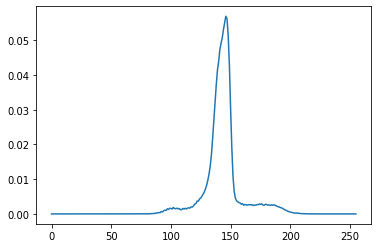

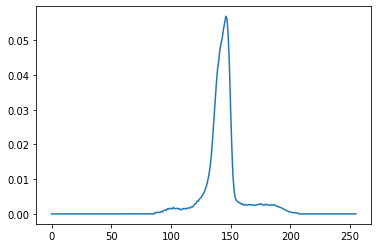

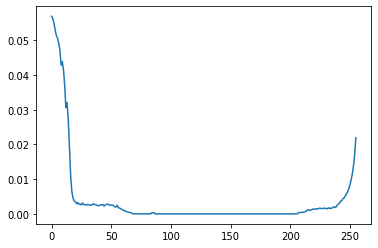

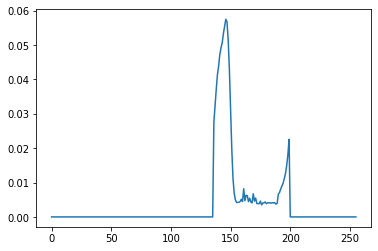

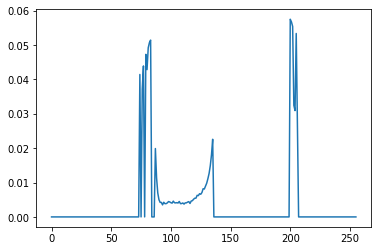

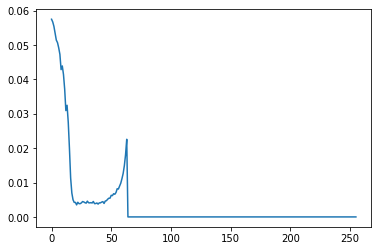

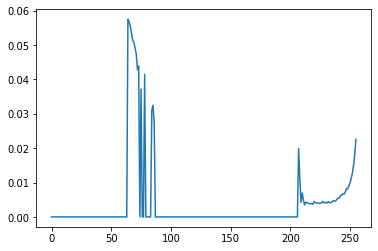

In [9]:
'''Do not run this cell, it takes time'''

img_file = '2.1.03.tiff'

intensities = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
unique, counts = np.unique(intensities, return_counts=True)

fintensities = intensities.astype(np.float)

height = np.shape(intensities)[0]
width = np.shape(intensities)[1]

u = unique.copy()
c = counts.copy()
for i in range(0,unique[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique[-1])
all_counts = np.append(c,z)
a = np.array(range(unique[-1]+1, 256))
var = np.append(u,a)

occurance_sum = sum(all_counts)
prbs = all_counts/occurance_sum

# plt.plot(var, all_counts)
plt.figure()
plt.plot(var, prbs)
plt.savefig('distribution')

prbs_org = np.where(prbs == 0, 0.000000001, prbs)
ent1 = np.log2(prbs_org)
ent2 = ent1 * prbs_org
entropy = -np.sum(ent2)
print('original entropy', entropy)

# print(intensities)
cv2.imshow('orig_image',intensities)
cv2.waitKey(1000)
filename = 'compressed_org_img.webp'
cv2.imwrite(filename, intensities)
cv2.waitKey(1000)

cells_num = 256

print('original image correlations:\n')
correlations(intensities)
######### ######### ######### ######### ######### ######### ######### #########
# NBIA
nb_all_yijs = []
nb_all_dijs = []
power = np.log2(cells_num)
for i in range(0,int(cells_num/2)):
    j = int(cells_num/2 + i)
#     print(i,j)

    '''Choose the strategy'''
# Strategy2
#     nb_yij = (var[i]+var[j])/2 # Strategy2
#     nb_all_yijs = np.append(nb_all_yijs, nb_yij) # Strategy2
    
#     nb_dij\
#         = var[i]**2*prbs[i] + nb_yij**2*prbs[i] - nb_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + nb_yij**2*prbs[j] - nb_yij*2*var[j]*prbs[j] # Strategy2

# Strategy3
    nb_dij = 0.5*(\
      var[i]**2*prbs[i] + var[i]**2*prbs[i] - var[i]*2*var[i]*prbs[i]\
    + var[j]**2*prbs[j] + var[i]**2*prbs[j] - var[i]*2*var[j]*prbs[j]\
    + var[i]**2*prbs[i] + var[j]**2*prbs[i] - var[j]*2*var[i]*prbs[i]\
    + var[j]**2*prbs[j] + var[j]**2*prbs[j] - var[j]*2*var[j]*prbs[j]) # Strategy3

    nb_all_dijs = np.append(nb_all_dijs, nb_dij)
    
nb_distortion = np.sum(nb_all_dijs)
nb_db = 10 * np.log10(nb_distortion)

nb_prb0s = prbs[0: int(cells_num/2)]  
nb_prb0 = sum(nb_prb0s)
nb_entropy = -nb_prb0*np.log2(nb_prb0)-(1-nb_prb0)*np.log2(1-nb_prb0)

# print('\n',nb_distortion)
print('\nnb_DE(dB)',nb_db)
print('nb_H(S0)',nb_entropy)

# NB MSB plane
nb_msb_plane = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        true_val = intensities[i][j]
        if true_val <= 127:
            nb_msb_plane[i][j] = 0 
        else:
            nb_msb_plane[i][j] = 1
            
nb_msb_plane255 = nb_msb_plane*255
nb_msb_uint8 = nb_msb_plane255.astype(np.uint8)
cv2.imshow('nb_msb_plane', nb_msb_uint8)
filename = 'nb_msb_plane_255.webp'
cv2.imwrite(filename, nb_msb_uint8)
cv2.waitKey(1000)

# NB 2nd MSB plane
nb_2nd_msb_plane = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        true_val = intensities[i][j]
        if true_val < 64 or 128 <= true_val < 192:
            nb_2nd_msb_plane[i][j] = 0 
        else:
            nb_2nd_msb_plane[i][j] = 1
            
nb_2nd_msb_plane255 = nb_2nd_msb_plane*255
nb_2nd_msb_uint8 = nb_2nd_msb_plane255.astype(np.uint8)
cv2.imshow('nb_2nd_msb_plane', nb_2nd_msb_uint8)
filename = 'nb_2nd_msb_plane_255.webp'
cv2.imwrite(filename, nb_2nd_msb_uint8)
cv2.waitKey(1000)
# MIP #######################################################################
all_yijs = []
all_dijs = []
all_prb0s = []
for i in range(0,cells_num-1):
    for j in range(i+1,cells_num):
        
        '''Choose the strategy'''
# Strategy1: Eve knows the source statistics which is rare in image encrytion
#         possible_yij = (var[i]*prbs[i]+var[j]*prbs[j])\ 
#                        /(prbs[i]+prbs[j])

# '''Choose one strategy'''
# # Strategy2: Eve knows the reconstruction value of each cell
#         possible_yij = (var[i]+var[j])/2
#         #possibel_yij = random.choice([var[i],var[j]])
        
#         all_yijs = np.append(all_yijs, possible_yij)
        
#         possible_dij\
#         = var[i]**2*prbs[i] + possible_yij**2*prbs[i] - possible_yij*2*var[i]*prbs[i]\
#         + var[j]**2*prbs[j] + possible_yij**2*prbs[j] - possible_yij*2*var[j]*prbs[j]
        
# Strategy3
        yi = var[i]
        yj = var[j]
        possible_dij = 0.5*(
          var[i]**2*prbs[i] + yi**2*prbs[i] - yi*2*var[i]*prbs[i]\
        + var[j]**2*prbs[j] + yi**2*prbs[j] - yi*2*var[j]*prbs[j]\
        + var[i]**2*prbs[i] + yj**2*prbs[i] - yj*2*var[i]*prbs[i]\
        + var[j]**2*prbs[j] + yj**2*prbs[j] - yj*2*var[j]*prbs[j])
        
               
        all_dijs = np.append(all_dijs, possible_dij)
                
        possible_prb0 = max(prbs[j],prbs[i])
        all_prb0s = np.append(all_prb0s, possible_prb0)

######### ######### ######### ######### ######### ######### ######### #########
'''For distortion and entropy, we must implement the integer linear programming.'''
'''Linear programming does not results in binary values'''

all_length = int(cells_num * (cells_num-1) / 2)

A_eq = np.zeros([cells_num, all_length])
k = 0
for i in range(0, cells_num-1):
    for j in range(i+1,cells_num):
        A_eq[i,k]=1
        k+=1
k = 0
for j in range(1, cells_num):
    for i in range (j,cells_num):
        A_eq[i,k]=1
        k+=1

b_eq = np.ones([cells_num,])


results_all_lambdas = []
# for Lambda in [0, 1000, 1000000]:
for Lambda in [0]:
    
    results = mip_entropy_constrained(Lambda)

    eve_msb0 = results[5]
    eve_msb1 = results[6]
    eve_msb00 = results[7]
    eve_msb01 = results[8]
    eve_msb10 = results[9]
    eve_msb11 = results[10]

    eve_dist0 = eve_distortion(eve_msb0)
    eve_dist1 = eve_distortion(eve_msb1)

    eve_dist = 0.5 * (eve_dist0 + eve_dist1)
    eve_dist_db = 10*np.log10(eve_dist)
    print('\n1_lam'+str(Lambda)+'_eve_distortion_1msb', eve_dist_db)

    eve_dist00 = eve_distortion(eve_msb00)
    eve_dist01 = eve_distortion(eve_msb01)
    eve_dist10 = eve_distortion(eve_msb10)
    eve_dist11 = eve_distortion(eve_msb11)

    eve_dist_2msb = 0.25*(eve_dist00+eve_dist01+eve_dist10+eve_dist11)
    eve_dist_db_2msb = 10*np.log10(eve_dist_2msb)
    print('1_lam'+str(Lambda)+'_eve_distortion_2msb', eve_dist_db_2msb)

    # Correlations
    corr0 = correlations(eve_msb0)
    corr1 = correlations(eve_msb1)
    
    hcorr_1msb = (corr0[0]+corr1[0])/2
    vcorr_1msb = (corr0[1]+corr1[1])/2
    dcorr_1msb = (corr0[2]+corr1[2])/2
    
    corr00 = correlations(eve_msb00)
    corr01 = correlations(eve_msb01)
    corr10 = correlations(eve_msb10)
    corr11 = correlations(eve_msb11)
        
    hcorr_2msb = (corr00[0]+corr01[0]+corr10[0]+corr11[0])/4
    vcorr_2msb = (corr00[1]+corr01[1]+corr10[1]+corr11[1])/4
    dcorr_2msb = (corr00[2]+corr01[2]+corr10[2]+corr11[2])/4
        
    print('\n1_lam'+str(Lambda)+'_correlation_msb0:\n')
    correlations(eve_msb0)

    print('\n1_lam'+str(Lambda)+'_correlation_msb1:\n')
    correlations(eve_msb1)
    
    print('1_lam'+str(Lambda)+'_average_hcorr_1msb',hcorr_1msb)
    print('1_lam'+str(Lambda)+'_average_vcorr_1msb',vcorr_1msb)
    print('1_lam'+str(Lambda)+'_average_dcorr_1msb',dcorr_1msb)
    
    print('\n1_lam'+str(Lambda)+'_correlation_msb00:\n')
    correlations(eve_msb00)

    print('\n1_lam'+str(Lambda)+'_correlation_msb01:\n')
    correlations(eve_msb01)

    print('\n1_lam'+str(Lambda)+'_correlation_msb10:\n')
    correlations(eve_msb10)

    print('\n1_lam'+str(Lambda)+'_correlation_msb11:\n')
    correlations(eve_msb11)
    
    print('1_lam'+str(Lambda)+'_average_hcorr_2msb',hcorr_2msb)
    print('1_lam'+str(Lambda)+'_average_vcorr_2msb',vcorr_2msb)
    print('1_lam'+str(Lambda)+'_average_dcorr_2msb',dcorr_2msb)
    
    # Histograms
    #MSB0
    unique_eve, counts_eve = np.unique(eve_msb0, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam'+str(Lambda)+'_histogram_msb0')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam'+str(Lambda)+'_msb0_entropy ', entropy)
    
    #MSB1
    unique_eve, counts_eve = np.unique(eve_msb1, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam'+str(Lambda)+'_histogram_msb1')

    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam'+str(Lambda)+'_msb1_entropy ', entropy)
    
    #MSB00
    unique_eve, counts_eve = np.unique(eve_msb00, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam'+str(Lambda)+'_histogram_msb00')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam'+str(Lambda)+'_msb00_entropy', entropy)
    
    #MSB01
    unique_eve, counts_eve = np.unique(eve_msb01, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam'+str(Lambda)+'_histogram_msb01')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam'+str(Lambda)+'_msb01_entropy', entropy)
    
    #MSB10
    unique_eve, counts_eve = np.unique(eve_msb10, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam'+str(Lambda)+'_histogram_msb10')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam'+str(Lambda)+'_msb10_entropy', entropy)
    
    #MSB11
    unique_eve, counts_eve = np.unique(eve_msb11, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam'+str(Lambda)+'_histogram_msb11')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam'+str(Lambda)+'_msb11_entropy', entropy)
    
    results_all_lambdas = np.append(results_all_lambdas, results)

In [11]:
cv2.destroyAllWindows()

hcorr 0.6554407076925607
vcorr 0.6772937737353252
dcorr 0.6230241938807762

nb_correlation_msb0:

hcorr 0.6554407076925607
vcorr 0.6772937737353252
dcorr 0.6230241938807762
nb_msb0_entropy  5.505412244502992
hcorr 0.6554407076925607
vcorr 0.6772937737353252
dcorr 0.6230241938807762

nb_correlation_msb1:

hcorr 0.6554407076925607
vcorr 0.6772937737353252
dcorr 0.6230241938807762
nb_msb1_entropy  5.505412244502992
nb_1msb_distortion 39.133899436317556
nb_average_hcorr_1msb 0.6554407076925607
nb_average_vcorr_1msb 0.6772937737353252
nb_average_dcorr_1msb 0.6230241938807762
hcorr 0.5812882391282532
vcorr 0.5927135272153874
dcorr 0.5380220574777091

nb_correlation_msb00:

hcorr 0.5812882391282532
vcorr 0.5927135272153874
dcorr 0.5380220574777091
nb_msb00_entropy  5.26595739538547
hcorr 0.5812882391282532
vcorr 0.5927135272153874
dcorr 0.5380220574777091

nb_correlation_msb01:

hcorr 0.5812882391282532
vcorr 0.5927135272153874
dcorr 0.5380220574777091
nb_msb01_entropy  5.265957395385472
hcor

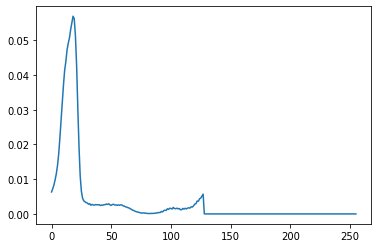

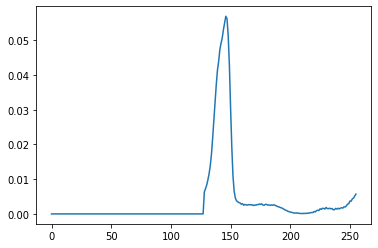

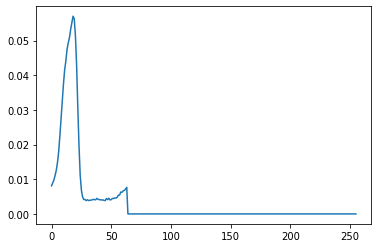

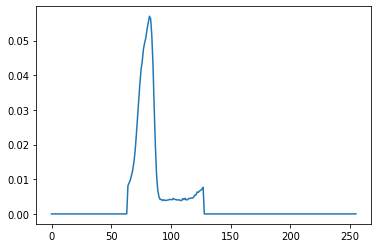

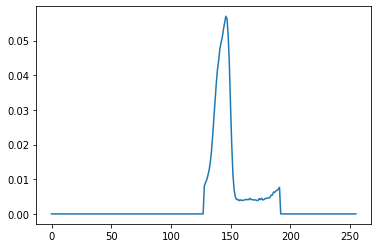

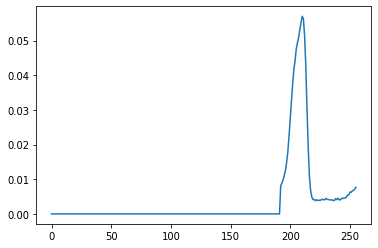

In [40]:
#NBIA
nb_msb = intensities.copy() #0
for i in range(0, height):
    for j in range(0, width):
        if 0 <= intensities[i][j] < 128:
            nb_msb[i][j] = intensities[i][j]
            
        if 128 <= intensities[i][j] < 256:
            nb_msb[i][j] = intensities[i][j] - 128
            
nb_distortion0 = eve_distortion(nb_msb)

msb_min = np.min(nb_msb)
msb_max = np.max(nb_msb)

scaled_1 = 255/(msb_max - msb_min) * (nb_msb - msb_min)
scaled_2 = np.round(scaled_1)
scaled = scaled_2.astype(np.uint8)

cv2.imshow('nb_msb0', nb_msb)
filename = 'nb_msb0.webp'
cv2.imwrite(filename, nb_msb)
cv2.waitKey(1000)

cv2.imshow('nb_msb0_hcont', scaled)
filename = 'nb_msb0_hcont.webp'
cv2.imwrite(filename, scaled)
cv2.waitKey(1000)

corr0 = correlations(nb_msb)
print('\nnb_correlation_msb0:\n')
correlations(nb_msb)

#Histogram
unique_eve, counts_eve = np.unique(nb_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('nb_histogram_msb0')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('nb_msb0_entropy ', entropy)


nb_msb = intensities.copy() #1
for i in range(0, height):
    for j in range(0, width):
        if 0 <= intensities[i][j] < 128:
            nb_msb[i][j] = intensities[i][j] + 128
            
        if 128 <= intensities[i][j] < 256:
            nb_msb[i][j] = intensities[i][j]
            
nb_distortion1 = eve_distortion(nb_msb)

msb_min = np.min(nb_msb)
msb_max = np.max(nb_msb)

scaled_1 = 255/(msb_max - msb_min) * (nb_msb - msb_min)
scaled_2 = np.round(scaled_1)
scaled = scaled_2.astype(np.uint8)

cv2.imshow('nb_msb1', nb_msb)
filename = 'nb_msb1.webp'
cv2.imwrite(filename, nb_msb)
cv2.waitKey(1000)

cv2.imshow('nb_msb1_hcont', scaled)
filename = 'nb_msb1_hcont.webp'
cv2.imwrite(filename, scaled)
cv2.waitKey(1000)

corr1 = correlations(nb_msb)
print('\nnb_correlation_msb1:\n')
correlations(nb_msb)

#Histogram
unique_eve, counts_eve = np.unique(nb_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('nb_histogram_msb1')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('nb_msb1_entropy ', entropy)


nb_1msb_distortion_1 = 0.5*(nb_distortion0+nb_distortion1)
nb_1msb_distortion = 10*np.log10(nb_1msb_distortion_1)
print('nb_1msb_distortion',nb_1msb_distortion)

hcorr_1msb = (corr0[0]+corr1[0])/2
vcorr_1msb = (corr0[1]+corr1[1])/2
dcorr_1msb = (corr0[2]+corr1[2])/2

print('nb_average_hcorr_1msb',hcorr_1msb)
print('nb_average_vcorr_1msb',vcorr_1msb)
print('nb_average_dcorr_1msb',dcorr_1msb)


nb_msb = intensities.copy() #00
for i in range(0, height):
    for j in range(0, width):
        if 0 <= intensities[i][j] < 64:
            nb_msb[i][j] = intensities[i][j]
            
        if 64 <= intensities[i][j] < 128:
            nb_msb[i][j] = intensities[i][j] - 64
       
        if 128 <= intensities[i][j] < 192:
            nb_msb[i][j] = intensities[i][j] - 128   
         
        if 192 <= intensities[i][j] < 256:
            nb_msb[i][j] = intensities[i][j] - 128-64
            
nb_distortion00 = eve_distortion(nb_msb)

msb_min = np.min(nb_msb)
msb_max = np.max(nb_msb)

scaled_1 = 255/(msb_max - msb_min) * (nb_msb - msb_min)
scaled_2 = np.round(scaled_1)
scaled = scaled_2.astype(np.uint8)

cv2.imshow('nb_msb00', nb_msb)
filename = 'nb_msb00.webp'
cv2.imwrite(filename, nb_msb)
cv2.waitKey(1000)

cv2.imshow('nb_msb00_hcont', scaled)
filename = 'nb_msb00_hcont.webp'
cv2.imwrite(filename, scaled)
cv2.waitKey(1000)

corr00 = correlations(nb_msb)
print('\nnb_correlation_msb00:\n')
correlations(nb_msb)

#Histogram
unique_eve, counts_eve = np.unique(nb_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('nb_histogram_msb00')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('nb_msb00_entropy ', entropy)


nb_msb = intensities.copy() #01
for i in range(0, height):
    for j in range(0, width):
        if 0 <= intensities[i][j] < 64:
            nb_msb[i][j] = intensities[i][j]+64
            
        if 64 <= intensities[i][j] < 128:
            nb_msb[i][j] = intensities[i][j]
       
        if 128 <= intensities[i][j] < 192:
            nb_msb[i][j] = intensities[i][j] - 64   
         
        if 192 <= intensities[i][j] < 256:
            nb_msb[i][j] = intensities[i][j] - 128
            
nb_distortion01 = eve_distortion(nb_msb)

msb_min = np.min(nb_msb)
msb_max = np.max(nb_msb)

scaled_1 = 255/(msb_max - msb_min) * (nb_msb - msb_min)
scaled_2 = np.round(scaled_1)
scaled = scaled_2.astype(np.uint8)

cv2.imshow('nb_msb01', nb_msb)
filename = 'nb_msb01.webp'
cv2.imwrite(filename, nb_msb)
cv2.waitKey(1000)

cv2.imshow('nb_msb01_hcont', scaled)
filename = 'nb_msb01_hcont.webp'
cv2.imwrite(filename, scaled)
cv2.waitKey(1000)

corr01 = correlations(nb_msb)
print('\nnb_correlation_msb01:\n')
correlations(nb_msb)

#Histogram
unique_eve, counts_eve = np.unique(nb_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('nb_histogram_msb01')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('nb_msb01_entropy ', entropy)


nb_msb = intensities.copy() #10
for i in range(0, height):
    for j in range(0, width):
        if 0 <= intensities[i][j] < 64:
            nb_msb[i][j] = intensities[i][j]+128
            
        if 64 <= intensities[i][j] < 128:
            nb_msb[i][j] = intensities[i][j] + 64
       
        if 128 <= intensities[i][j] < 192:
            nb_msb[i][j] = intensities[i][j]   
         
        if 192 <= intensities[i][j] < 256:
            nb_msb[i][j] = intensities[i][j] - 64
            
nb_distortion10 = eve_distortion(nb_msb)

msb_min = np.min(nb_msb)
msb_max = np.max(nb_msb)

scaled_1 = 255/(msb_max - msb_min) * (nb_msb - msb_min)
scaled_2 = np.round(scaled_1)
scaled = scaled_2.astype(np.uint8)

cv2.imshow('nb_msb10', nb_msb)
filename = 'nb_msb10.webp'
cv2.imwrite(filename, nb_msb)
cv2.waitKey(1000)

cv2.imshow('nb_msb10_hcont', scaled)
filename = 'nb_msb10_hcont.webp'
cv2.imwrite(filename, scaled)
cv2.waitKey(1000)

corr10 = correlations(nb_msb)
print('\nnb_correlation_msb10:\n')
correlations(nb_msb)

#Histogram
unique_eve, counts_eve = np.unique(nb_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('nb_histogram_msb10')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('nb_msb10_entropy ', entropy)


nb_msb = intensities.copy() #11
for i in range(0, height):
    for j in range(0, width):
        if 0 <= intensities[i][j] < 64:
            nb_msb[i][j] = intensities[i][j]+192
            
        if 64 <= intensities[i][j] < 128:
            nb_msb[i][j] = intensities[i][j]+128
       
        if 128 <= intensities[i][j] < 192:
            nb_msb[i][j] = intensities[i][j]+64  
         
        if 192 <= intensities[i][j] < 256:
            nb_msb[i][j] = intensities[i][j]
            
nb_distortion11 = eve_distortion(nb_msb)

msb_min = np.min(nb_msb)
msb_max = np.max(nb_msb)

scaled_1 = 255/(msb_max - msb_min) * (nb_msb - msb_min)
scaled_2 = np.round(scaled_1)
scaled = scaled_2.astype(np.uint8)

cv2.imshow('nb_msb11', nb_msb)
filename = 'nb_msb11.webp'
cv2.imwrite(filename, nb_msb)
cv2.waitKey(1000)

cv2.imshow('nb_msb11_hcont', scaled)
filename = 'nb_msb11_hcont.webp'
cv2.imwrite(filename, scaled)
cv2.waitKey(1000)

corr11 = correlations(nb_msb)
print('\nnb_correlation_msb11:\n')
correlations(nb_msb)

#Histogram
unique_eve, counts_eve = np.unique(nb_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('nb_histogram_eve_msb11')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('nb_msb11_entropy ', entropy)


nb_2msb_distortion_1 = 0.25*(nb_distortion00+nb_distortion01
                            +nb_distortion10+nb_distortion11)
nb_2msb_distortion = 10*np.log10(nb_2msb_distortion_1)
print('nb_2msb_distortion',nb_2msb_distortion)

hcorr_2msb = (corr00[0]+corr01[0]+corr10[0]+corr11[0])/4
vcorr_2msb = (corr00[1]+corr01[1]+corr10[1]+corr11[1])/4
dcorr_2msb = (corr00[2]+corr01[2]+corr10[2]+corr11[2])/4

print('nb_average_hcorr_2msb',hcorr_2msb)
print('nb_average_vcorr_2msb',vcorr_2msb)
print('nb_average_dcorr_2msb',dcorr_2msb)

In [41]:
cv2.destroyAllWindows()

In [58]:
###################################################################
#MIP Index Assignment (For Random and Not Entropy Consideration)
import random

#random msb assignment to each pair(then it will be fixed)
# random.seed(0) #seed1
# random.seed(2) #seed2
random.seed(4) #seed3

mip_pairs_show = results[0]
dual_mip_xx = results[11]

ord_pairs = mip_pairs_show.copy()
for i in range(0, int(cells_num/2)):
    if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
        ord_pairs[0][i] = mip_pairs_show[1][i]
        ord_pairs[1][i] = mip_pairs_show[0][i]
        
all_msb0_pairs = []
for i in range(0, int(cells_num/2)):
    pair = [ord_pairs[0][i], ord_pairs[1][i]]
    msb0_pair = pair[random.randint(0,1)]
    all_msb0_pairs = np.append(all_msb0_pairs,msb0_pair)  

#random pair assignment to 128 pairs
# random.seed(1) #seed1
# random.seed(3) #seed2
random.seed(5) #seed3

rand_pair_indexes = []
num_pairs_set = list(range(128))
for i in range(128):
    rand_index = random.choice(num_pairs_set)
    rand_pair_indexes = np.append(rand_pair_indexes, rand_index)
    num_pairs_set.remove(rand_index)

pairs_with_index = np.array([ord_pairs[0], ord_pairs[1], rand_pair_indexes])
#Random Planes######################################################
# MIP MSB plane
mip_2rand_msb_plane = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] in all_msb0_pairs:
            mip_2rand_msb_plane[i][j] = 0
        else:
            mip_2rand_msb_plane[i][j] = 1

mip_2rand_msb_plane255 = mip_2rand_msb_plane*255
mip_2rand_msb_uint8 = mip_2rand_msb_plane255.astype(np.uint8)
cv2.imshow('random_msb_plane255_lam'+str(Lambda), mip_2rand_msb_uint8)
filename = 'random_msb_plane255_lam'+str(Lambda)+'.webp'
cv2.imwrite(filename, mip_2rand_msb_uint8)
cv2.waitKey(1000)

# MIP 2nd MSB plane
mip_2rand_2nd_msb_plane = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(
            pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
              
        if pair_index < 64:
            mip_2rand_2nd_msb_plane[i][j] = 0
        else:
            mip_2rand_2nd_msb_plane[i][j] = 1

mip_2rand_2nd_msb_plane255 = mip_2rand_2nd_msb_plane*255
mip_2rand_2nd_msb_uint8 = mip_2rand_2nd_msb_plane255.astype(np.uint8)
cv2.imshow('random_2nd_msb_plane_lam'+str(Lambda), mip_2rand_2nd_msb_uint8)
filename = 'random_2nd_msb_plane255_lam'+str(Lambda)+'.webp'
cv2.imwrite(filename, mip_2rand_2nd_msb_uint8)
cv2.waitKey(1000)

-1

In [59]:
cv2.destroyAllWindows()

hcorr 0.2578268070886732
vcorr 0.2631749926206633
dcorr 0.24242472002568452

3_correlation_msb0:

hcorr 0.2578268070886732
vcorr 0.2631749926206633
dcorr 0.24242472002568452
3_msb0_entropy  5.502865941421291
hcorr 0.19371701757583126
vcorr 0.19854339214059608
dcorr 0.1801514531749627

3_correlation_msb1:

hcorr 0.19371701757583126
vcorr 0.19854339214059608
dcorr 0.1801514531749627
3_msb1_entropy 5.502865941421292
3_1msb_distortion 39.561616518724
3_average_hcorr_1msb_randomMSBLSB 0.22577191233225224
3_average_vcorr_1msb_randomMSBLSB 0.23085919238062969
3_average_dcorr_1msb_randomMSBLSB 0.2112880866003236
hcorr 0.05711164566484151
vcorr 0.05869537893339108
dcorr 0.05430721064048973

3_correlation_msb00:

hcorr 0.05711164566484151
vcorr 0.05869537893339108
dcorr 0.05430721064048973
3_msb00_entropy  4.997731544663695
hcorr 0.19720963389891552
vcorr 0.20415940880304675
dcorr 0.18584649500503972

3_correlation_msb01:

hcorr 0.19720963389891552
vcorr 0.20415940880304675
dcorr 0.1858464950050

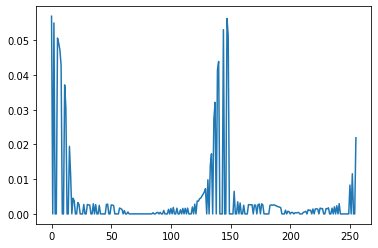

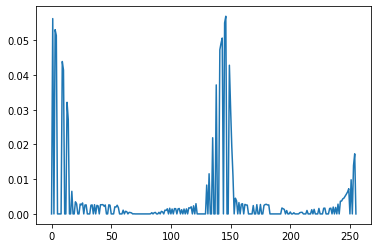

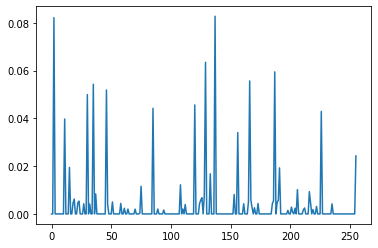

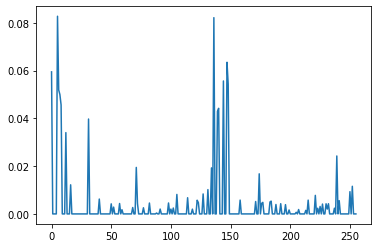

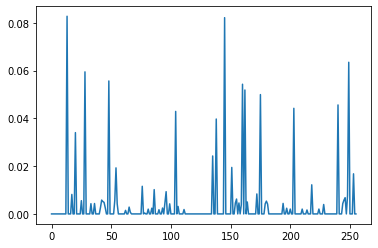

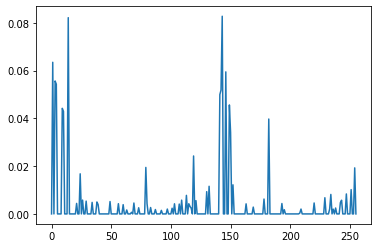

In [60]:
################################################################
# Random MSB and Random LSBs
#MIP: Eve reconstruction, just 1 msb, 0 or 1
dual_mip_xx = results[11]
mip_random_msb = intensities.copy() #0
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] in all_msb0_pairs:
            mip_random_msb[i][j] = intensities[i][j]
        else:
            paired_cell = np.where(
                dual_mip_xx[intensities[i][j]] == 1)
            mip_random_msb[i][j] = paired_cell[0]
            
mip_distortion0 = eve_distortion(mip_random_msb)
            
cv2.imshow('3_msb0', mip_random_msb)
filename = '3_msb0.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr0 = correlations(mip_random_msb)
print('\n3_correlation_msb0:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('3_histogram_msb0')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('3_msb0_entropy ', entropy)


mip_random_msb = intensities.copy() #1
for i in range(0,height):
    for j in range(0,width):
        if intensities[i][j] in all_msb0_pairs:
            paired_cell = np.where(
                dual_mip_xx[intensities[i][j]] == 1)
            mip_random_msb[i][j] = paired_cell[0]
        else:
            mip_random_msb[i][j] = intensities[i][j]
            
mip_distortion1 = eve_distortion(mip_random_msb)

cv2.imshow('3_msb1', mip_random_msb)
filename = '3_msb1.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr1 = correlations(mip_random_msb)
print('\n3_correlation_msb1:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('3_histogram_msb1')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('3_msb1_entropy', entropy)


mip_1msb_distortion_1 = 0.5*(mip_distortion0+mip_distortion1)
mip_1msb_distortion = 10*np.log10(mip_1msb_distortion_1)
print('3_1msb_distortion',mip_1msb_distortion)

hcorr_1msb = (corr0[0]+corr1[0])/2
vcorr_1msb = (corr0[1]+corr1[1])/2
dcorr_1msb = (corr0[2]+corr1[2])/2

print('3_average_hcorr_1msb_randomMSBLSB',hcorr_1msb)
print('3_average_vcorr_1msb_randomMSBLSB',vcorr_1msb)
print('3_average_dcorr_1msb_randomMSBLSB',dcorr_1msb)


mip_random_msb = intensities.copy() #00
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)-64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2                
                
mip_distortion00 = eve_distortion(mip_random_msb)

cv2.imshow('3_msb00', mip_random_msb)
filename = '3_msb00.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr00 = correlations(mip_random_msb)
print('\n3_correlation_msb00:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('3_histogram_msb00')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('3_msb00_entropy ', entropy)


mip_random_msb = intensities.copy() #01
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)+64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2                
                
mip_distortion01 = eve_distortion(mip_random_msb)               
cv2.imshow('3_msb01', mip_random_msb)
filename = '3_msb01.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr01 = correlations(mip_random_msb)
print('\n3_correlation_msb01:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('3_histogram_msb01')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('3_msb01_entropy ', entropy)


mip_random_msb = intensities.copy() #10
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)-64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1               
                
mip_distortion10 = eve_distortion(mip_random_msb)               
cv2.imshow('3_msb10', mip_random_msb)
filename = '3_msb10.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr10 = correlations(mip_random_msb)
print('\n3_correlation_msb10:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('3_histogram_msb10')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('3_msb10_entropy', entropy)


mip_random_msb = intensities.copy() #11
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)+64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if alter1 in all_msb0_pairs:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1               
                
mip_distortion11 = eve_distortion(mip_random_msb)               
cv2.imshow('3_msb11', mip_random_msb)
filename = '3_msb11.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr11 = correlations(mip_random_msb)
print('\n3_correlation_msb11:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('3_histogram_msb11')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('3_msb11_entropy', entropy)
    
    
mip_2msb_distortion_1 = 0.25*(mip_distortion00+mip_distortion01
                             +mip_distortion10+mip_distortion11)
mip_2msb_distortion = 10*np.log10(mip_2msb_distortion_1)
print('3_2msb_distortion',mip_2msb_distortion)

hcorr_2msb = (corr00[0]+corr01[0]+corr10[0]+corr11[0])/4
vcorr_2msb = (corr00[1]+corr01[1]+corr10[1]+corr11[1])/4
dcorr_2msb = (corr00[2]+corr01[2]+corr10[2]+corr11[2])/4

print('3_average_hcorr_2msb',hcorr_2msb)
print('3_average_vcorr_2msb',vcorr_2msb)
print('3_average_dcorr_2msb',dcorr_2msb)

In [61]:
cv2.destroyAllWindows()

hcorr 0.7879861157474235
vcorr 0.8244716094925514
dcorr 0.728441096803476

2_lam0_correlation_msb0:

hcorr 0.7879861157474235
vcorr 0.8244716094925514
dcorr 0.728441096803476
2_lam0_msb0_entropy  5.5028735409184675
hcorr 0.6601031915498682
vcorr 0.679791717534313
dcorr 0.6296197717171578

2_lam0_correlation_msb1:

hcorr 0.6601031915498682
vcorr 0.679791717534313
dcorr 0.6296197717171578
2_lam0_msb1_entropy  5.502873540918468
2_lam0_1msb_distortion 39.56161648940138
2_lam0_average_hcorr_1msb 0.7240446536486458
2_lam0_average_vcorr_1msb 0.7521316635134322
2_lam0_average_dcorr_1msb 0.6790304342603168
hcorr 0.14197053049702948
vcorr 0.14005752759004517
dcorr 0.12557690763928964

2_lam0_correlation_msb00:

hcorr 0.14197053049702948
vcorr 0.14005752759004517
dcorr 0.12557690763928964
2_lam0_msb00_entropy  4.997731544663695
hcorr 0.4521323090660673
vcorr 0.4595941882380327
dcorr 0.4349441398516236

2_lam0_correlation_msb01:

hcorr 0.4521323090660673
vcorr 0.4595941882380327
dcorr 0.4349441398

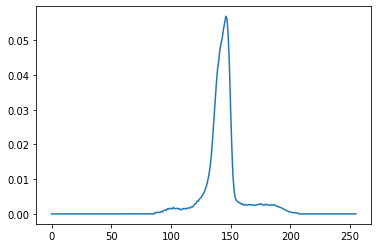

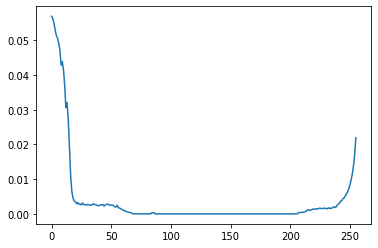

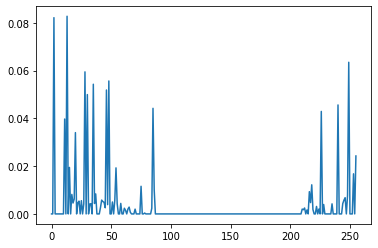

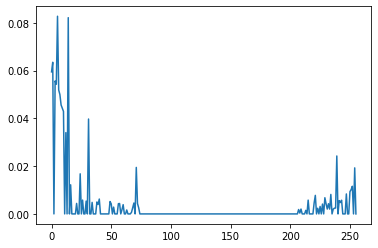

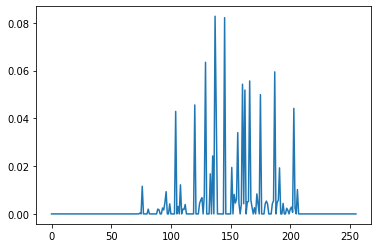

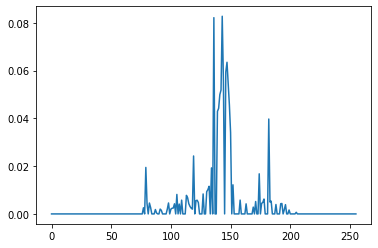

In [62]:
######################################################################    
# Entropy constrained MSB and Random LSBs  
dual_mip_xx = results[11]
mip_random_msb = intensities.copy() #0

for i in range(0,height):
    for j in range(0,width):
        paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
        if prbs[intensities[i][j]] < prbs[paired_cell]:
            mip_random_msb[i][j] = paired_cell[0]
            
mip_entropy_distortion0 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam0_msb0', mip_random_msb)
filename = '2_lam0_msb0.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr0 = correlations(mip_random_msb)
print('\n2_lam0_correlation_msb0:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam0_histogram_msb0')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam0_msb0_entropy ', entropy)


mip_random_msb = intensities.copy() #1

for i in range(0,height):
    for j in range(0,width):
        paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
        if prbs[intensities[i][j]] > prbs[paired_cell]:
            mip_random_msb[i][j] = paired_cell[0]
            
mip_entropy_distortion1 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam0_msb1', mip_random_msb)
filename = '2_lam0_msb1.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr1 = correlations(mip_random_msb)
print('\n2_lam0_correlation_msb1:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam0_histogram_msb1')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam0_msb1_entropy ', entropy)


mip_1msb_distortion_1 = 0.5*(mip_entropy_distortion0+mip_entropy_distortion1)
mip_1msb_distortion = 10*np.log10(mip_1msb_distortion_1)
print('2_lam0_1msb_distortion',mip_1msb_distortion)

hcorr_1msb = (corr0[0]+corr1[0])/2
vcorr_1msb = (corr0[1]+corr1[1])/2
dcorr_1msb = (corr0[2]+corr1[2])/2

print('2_lam0_average_hcorr_1msb',hcorr_1msb)
print('2_lam0_average_vcorr_1msb',vcorr_1msb)
print('2_lam0_average_dcorr_1msb',dcorr_1msb)


mip_random_msb = intensities.copy() #00
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)-64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
            
mip_entropy_distortion00 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam0_msb00', mip_random_msb)
filename = '2_lam0_msb00.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr00 = correlations(mip_random_msb)
print('\n2_lam0_correlation_msb00:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam0_histogram_msb00')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam0_msb00_entropy ', entropy)


mip_random_msb = intensities.copy() #01
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)+64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
            
mip_entropy_distortion01 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam0_msb01', mip_random_msb)
filename = '2_lam0_msb01.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr01 = correlations(mip_random_msb)
print('\n2_lam0_correlation_msb01:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam0_histogram_msb01')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam0_msb01_entropy ', entropy)


mip_random_msb = intensities.copy() #10
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)-64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
            
mip_entropy_distortion10 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam0_msb10', mip_random_msb)
filename = '2_lam0_msb10.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr10 = correlations(mip_random_msb)
print('\n2_lam0_correlation_msb10:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam0_histogram_msb10')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam0_msb10_entropy ', entropy)


mip_random_msb = intensities.copy() #11
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)+64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
            
mip_entropy_distortion11 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam0_msb11', mip_random_msb)
filename = '2_lam0_msb11.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr11 = correlations(mip_random_msb)
print('\n2_lam0_correlation_msb11:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam0_histogram_msb11')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam0_msb11_entropy ', entropy)


mip_entropy_2msb_distortion_1 = 0.25*(mip_entropy_distortion00
                                     +mip_entropy_distortion01
                                     +mip_entropy_distortion10
                                     +mip_entropy_distortion11)
mip_entropy_2msb_distortion = 10*np.log10(mip_entropy_2msb_distortion_1)
print('2_lam0_entropy_2msb_distortion',mip_entropy_2msb_distortion)

hcorr_2msb = (corr00[0]+corr01[0]+corr10[0]+corr11[0])/4
vcorr_2msb = (corr00[1]+corr01[1]+corr10[1]+corr11[1])/4
dcorr_2msb = (corr00[2]+corr01[2]+corr10[2]+corr11[2])/4

print('2_lam0_average_hcorr_2msb',hcorr_2msb)
print('2_lam0_average_vcorr_2msb',vcorr_2msb)
print('2_lam0_average_dcorr_2msb',dcorr_2msb)

In [63]:
cv2.destroyAllWindows()

hcorr 0.03534072869181687
vcorr 0.035388838104456685
dcorr 0.03313254024814173

total_correlation_msb0:

hcorr 0.03534072869181687
vcorr 0.035388838104456685
dcorr 0.03313254024814173
total_msb0_entropy  5.243215685537054
hcorr 0.06952040692326585
vcorr 0.07471621610562601
dcorr 0.06386753251858013

total_correlation_msb1:

hcorr 0.06952040692326585
vcorr 0.07471621610562601
dcorr 0.06386753251858013
total_msb1_entropy  5.243215685537056
total_1msb_distortion  32.84997880609598
total_average_hcorr_1msb  0.05243056780754136
total_average_vcorr_1msb  0.05505252710504135
total_average_dcorr_1msb  0.04850003638336093
hcorr 0.0462986366842305
vcorr 0.047754111019676866
dcorr 0.044021727207172956

total_correlation_msb00:

hcorr 0.0462986366842305
vcorr 0.047754111019676866
dcorr 0.044021727207172956
total_msb00_entropy  4.995772029307617
hcorr 0.0464777832346498
vcorr 0.04643303505041884
dcorr 0.0374160074757505

total_correlation_msb01:

hcorr 0.0464777832346498
vcorr 0.04643303505041884
d

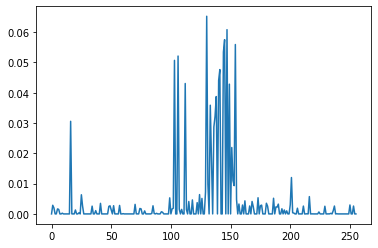

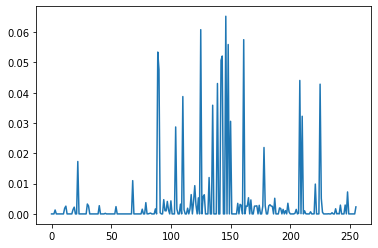

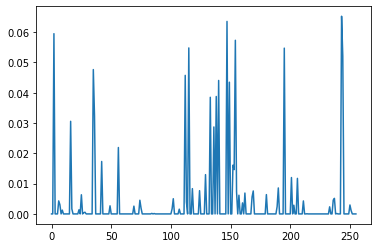

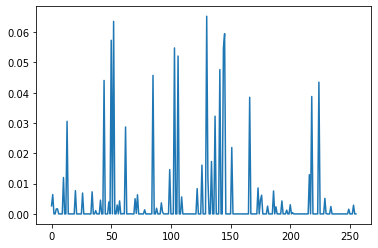

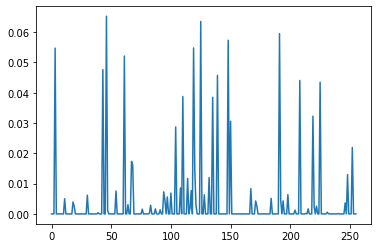

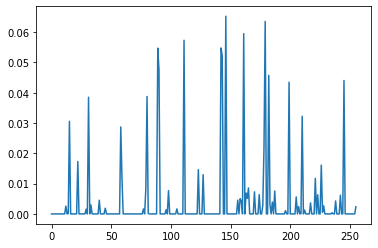

In [64]:
#####################################################################    
# Total random index assignment    
# random.seed(0) #seed1
# random.seed(2) #seed2
random.seed(4) #seed3

rand_indexes = []
cells_num_set = list(range(256))
for i in range(256):
    rand_index = random.choice(cells_num_set)
    rand_indexes = np.append(rand_indexes, rand_index)
    cells_num_set.remove(rand_index)

cells_value = np.array(range(256))
values_with_indexes = np.array([cells_value, rand_indexes])

#0
total_random = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        value_index = values_with_indexes[1][intensities[i][j]]
        if value_index >= 128:
            paired_index = value_index - 128
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
total_rand_msb0_distortion = eve_distortion(total_random)
            
cv2.imshow('total_msb0', total_random)
filename = 'total_msb0.webp'
cv2.imwrite(filename, total_random)
cv2.waitKey(1000)

corr0 = correlations(total_random)
print('\ntotal_correlation_msb0:\n')
correlations(total_random)

#Histogram
unique_eve, counts_eve = np.unique(total_random, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('total_histogram_msb0')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('total_msb0_entropy ', entropy)


# 1
total_random = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        value_index = values_with_indexes[1][intensities[i][j]]
        if value_index < 128:
            paired_index = value_index + 128
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value

total_rand_msb1_distortion = eve_distortion(total_random)
            
cv2.imshow('total_msb1', total_random)
filename = 'total_msb1.webp'
cv2.imwrite(filename, total_random)
cv2.waitKey(1000)

corr1 = correlations(total_random)
print('\ntotal_correlation_msb1:\n')
correlations(total_random)

#Histogram
unique_eve, counts_eve = np.unique(total_random, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('total_histogram_msb1')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('total_msb1_entropy ', entropy)


total_rand_1msb_distortion_1 = 0.5 * (total_rand_msb0_distortion
                                   +total_rand_msb1_distortion)
total_rand_msb1_distortion = 10 * np.log10(total_rand_1msb_distortion_1)
print('total_1msb_distortion ',total_rand_msb1_distortion)

hcorr_1msb = (corr0[0]+corr1[0])/2
vcorr_1msb = (corr0[1]+corr1[1])/2
dcorr_1msb = (corr0[2]+corr1[2])/2

print('total_average_hcorr_1msb ',hcorr_1msb)
print('total_average_vcorr_1msb ',vcorr_1msb)
print('total_average_dcorr_1msb ',dcorr_1msb)


# 00
total_random = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        value_index = values_with_indexes[1][intensities[i][j]]
        if value_index < 64:
            total_random[i][j] = intensities[i][j]
        
        if 64 <= value_index < 128:
            paired_index = value_index - 64
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 128 <= value_index < 192:
            paired_index = value_index - 128
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 192 <= value_index < 256:
            paired_index = value_index - 192
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
cv2.imshow('total_msb00', total_random)
filename = 'total_msb00.webp'
cv2.imwrite(filename, total_random)
cv2.waitKey(1000)

total_rand_msb00_distortion = eve_distortion(total_random)

corr00 = correlations(total_random)
print('\ntotal_correlation_msb00:\n')
correlations(total_random)

#Histogram
unique_eve, counts_eve = np.unique(total_random, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('total_histogram_msb00')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('total_msb00_entropy ', entropy)

# 01
total_random = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        value_index = values_with_indexes[1][intensities[i][j]]
        if value_index < 64:            
            paired_index = value_index + 64
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
           
        if 64 <= value_index < 128:
            paired_index = value_index
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 128 <= value_index < 192:
            paired_index = value_index - 64
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 192 <= value_index < 256:
            paired_index = value_index - 128
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
cv2.imshow('total_msb01', total_random)
filename = 'total_msb01.webp'
cv2.imwrite(filename, total_random)
cv2.waitKey(1000)

total_rand_msb01_distortion = eve_distortion(total_random)

corr01 = correlations(total_random)
print('\ntotal_correlation_msb01:\n')
correlations(total_random)

#Histogram
unique_eve, counts_eve = np.unique(total_random, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('total_histogram_msb01')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('total_msb01_entropy ', entropy)

# 10
total_random = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        value_index = values_with_indexes[1][intensities[i][j]]
        if value_index < 64:            
            paired_index = value_index + 128
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
           
        if 64 <= value_index < 128:
            paired_index = value_index + 64
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 128 <= value_index < 192:
            paired_index = value_index
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 192 <= value_index < 256:
            paired_index = value_index - 64
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
cv2.imshow('total_msb10', total_random)
filename = 'total_msb10.webp'
cv2.imwrite(filename, total_random)
cv2.waitKey(1000)

total_rand_msb10_distortion = eve_distortion(total_random)

corr10 = correlations(total_random)
print('\ntotal_correlation_msb10:\n')
correlations(total_random)

#Histogram
unique_eve, counts_eve = np.unique(total_random, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('total_histogram_msb10')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('total_msb10_entropy ', entropy)

# 11
total_random = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        value_index = values_with_indexes[1][intensities[i][j]]
        if value_index < 64:            
            paired_index = value_index + 192
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
           
        if 64 <= value_index < 128:
            paired_index = value_index + 128
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 128 <= value_index < 192:
            paired_index = value_index + 64
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 192 <= value_index < 256:
            paired_index = value_index 
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
cv2.imshow('total_msb11', total_random)
filename = 'total_msb11.webp'
cv2.imwrite(filename, total_random)
cv2.waitKey(1000)

total_rand_msb11_distortion = eve_distortion(total_random)

corr11 = correlations(total_random)
print('\ntotal_correlation_msb11:\n')
correlations(total_random)

#Histogram
unique_eve, counts_eve = np.unique(total_random, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('total_histogram_msb11')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('total_msb11_entropy ', entropy)


total_rand_2msb_distortion_1 = 0.25*(total_rand_msb00_distortion
                                    +total_rand_msb01_distortion
                                    +total_rand_msb10_distortion
                                    +total_rand_msb11_distortion)

total_rand_2msb_distortion = 10*np.log10(total_rand_2msb_distortion_1)
print('total_2msb_distortion ', total_rand_2msb_distortion)

hcorr_2msb = (corr00[0]+corr01[0]+corr10[0]+corr11[0])/4
vcorr_2msb = (corr00[1]+corr01[1]+corr10[1]+corr11[1])/4
dcorr_2msb = (corr00[2]+corr01[2]+corr10[2]+corr11[2])/4

print('total_average_hcorr_2msb ',hcorr_2msb)
print('total_average_vcorr_2msb ',vcorr_2msb)
print('total_average_dcorr_2msb ',dcorr_2msb)


# 000
total_random = intensities.copy()
for i in range(0,height):
    for j in range(0,width):
        value_index = values_with_indexes[1][intensities[i][j]]
        if value_index < 32:
            total_random[i][j] = intensities[i][j]
        
        if 32 <= value_index < 64:
            paired_index = value_index - 32
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 64 <= value_index < 96:
            paired_index = value_index - 64
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 96 <= value_index < 128:
            paired_index = value_index - 96
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 128 <= value_index < 160:
            paired_index = value_index - 128
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 160 <= value_index < 192:
            paired_index = value_index - 160
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 192 <= value_index < 224:
            paired_index = value_index - 192
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
            
        if 224 <= value_index < 256:
            paired_index = value_index - 224
            position_1 = np.where(values_with_indexes == paired_index)
            position = position_1[1][1]
            paired_value = values_with_indexes[0][position]
            total_random[i][j] = paired_value
              
cv2.imshow('total_msb000', total_random)
filename = 'total_msb000.webp'
cv2.imwrite(filename, total_random)
cv2.waitKey(1000)

total_rand_msb000_distortion = 10 * np.log10(eve_distortion(total_random))
print('total_msb000_distortion', total_rand_msb000_distortion)

In [65]:
cv2.destroyAllWindows()


1_DE(dB)_lam1000000 39.55680174918041
1_H(S0)_lam1000000 0.005098178322400854

1_eve_distortion_1msb_lam1000000 39.55680174918041
1_eve_distortion_2msb_lam1000000 38.238245436826844
hcorr 0.8157908036472711
vcorr 0.8470144406343892
dcorr 0.7553930911625619
hcorr 0.6681756476824109
vcorr 0.6852858484383498
dcorr 0.6347739403733279
hcorr 0.549697329423036
vcorr 0.5626429174158686
dcorr 0.5182318264646272
hcorr 0.5021489756630669
vcorr 0.5120763783466488
dcorr 0.48060467680782626
hcorr 0.6523183879230148
vcorr 0.6650011940457681
dcorr 0.625266587770788
hcorr 0.6913421882222216
vcorr 0.7049252417869307
dcorr 0.6655262820343304

1_correlation_lam1000000msb0:

hcorr 0.8157908036472711
vcorr 0.8470144406343892
dcorr 0.7553930911625619

1_correlation_lam1000000msb1:

hcorr 0.6681756476824109
vcorr 0.6852858484383498
dcorr 0.6347739403733279
1_average_hcorr_1msb_lam1000000 0.741983225664841
1_average_vcorr_1msb_lam1000000 0.7661501445363695
1_average_dcorr_1msb_lam1000000 0.6950835157679449

1

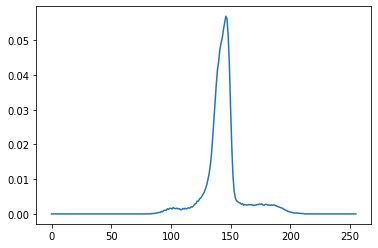

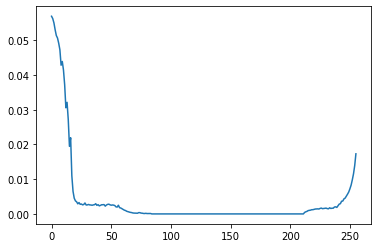

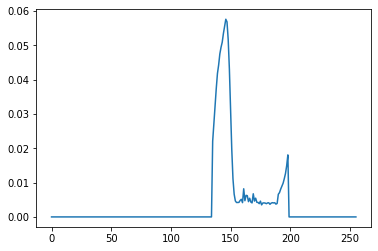

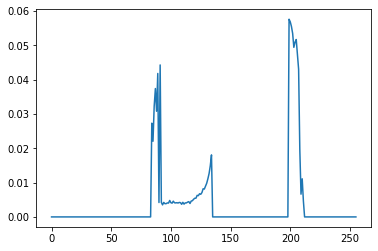

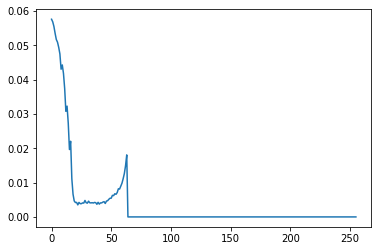

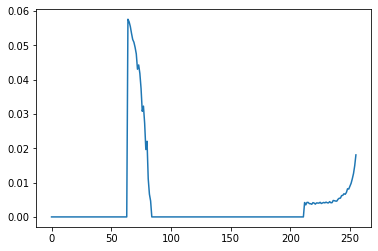

In [66]:
for Lambda in [1000000]:
    
    results = mip_entropy_constrained(Lambda)

    eve_msb0 = results[5]
    eve_msb1 = results[6]
    eve_msb00 = results[7]
    eve_msb01 = results[8]
    eve_msb10 = results[9]
    eve_msb11 = results[10]

    eve_dist0 = eve_distortion(eve_msb0)
    eve_dist1 = eve_distortion(eve_msb1)

    eve_dist = 0.5 * (eve_dist0 + eve_dist1)
    eve_dist_db = 10*np.log10(eve_dist)
    print('\n1_eve_distortion_1msb_lam'+str(Lambda), eve_dist_db)

    eve_dist00 = eve_distortion(eve_msb00)
    eve_dist01 = eve_distortion(eve_msb01)
    eve_dist10 = eve_distortion(eve_msb10)
    eve_dist11 = eve_distortion(eve_msb11)

    eve_dist_2msb = 0.25*(eve_dist00+eve_dist01+eve_dist10+eve_dist11)
    eve_dist_db_2msb = 10*np.log10(eve_dist_2msb)
    print('1_eve_distortion_2msb_lam'+str(Lambda), eve_dist_db_2msb)

    # Correlations
    corr0 = correlations(eve_msb0)
    corr1 = correlations(eve_msb1)
    
    hcorr_1msb = (corr0[0]+corr1[0])/2
    vcorr_1msb = (corr0[1]+corr1[1])/2
    dcorr_1msb = (corr0[2]+corr1[2])/2
    
    corr00 = correlations(eve_msb00)
    corr01 = correlations(eve_msb01)
    corr10 = correlations(eve_msb10)
    corr11 = correlations(eve_msb11)
        
    hcorr_2msb = (corr00[0]+corr01[0]+corr10[0]+corr11[0])/4
    vcorr_2msb = (corr00[1]+corr01[1]+corr10[1]+corr11[1])/4
    dcorr_2msb = (corr00[2]+corr01[2]+corr10[2]+corr11[2])/4
        
    print('\n1_correlation_lam'+str(Lambda)+'msb0:\n')
    correlations(eve_msb0)

    print('\n1_correlation_lam'+str(Lambda)+'msb1:\n')
    correlations(eve_msb1)
    
    print('1_average_hcorr_1msb_lam'+str(Lambda),hcorr_1msb)
    print('1_average_vcorr_1msb_lam'+str(Lambda),vcorr_1msb)
    print('1_average_dcorr_1msb_lam'+str(Lambda),dcorr_1msb)
    
    print('\n1_correlation_lam'+str(Lambda)+'_msb00:\n')
    correlations(eve_msb00)

    print('\n1_correlation_lam'+str(Lambda)+'_msb01:\n')
    correlations(eve_msb01)

    print('\n1_correlation_lam'+str(Lambda)+'_msb10:\n')
    correlations(eve_msb10)

    print('\n1_correlation_lam'+str(Lambda)+'_msb11:\n')
    correlations(eve_msb11)
    
    print('1_average_hcorr_2msb_lam'+str(Lambda),hcorr_2msb)
    print('1_average_vcorr_2msb_lam'+str(Lambda),vcorr_2msb)
    print('1_average_dcorr_2msb_lam'+str(Lambda),dcorr_2msb)
    
    # Histograms
    #MSB0
    unique_eve, counts_eve = np.unique(eve_msb0, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam1000000_histogram_msb0')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam1000000_msb0_entropy ', entropy)
    
    #MSB1
    unique_eve, counts_eve = np.unique(eve_msb1, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam1000000_histogram_msb1')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam1000000_msb1_entropy ', entropy)
    
    #MSB00
    unique_eve, counts_eve = np.unique(eve_msb00, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam1000000_histogram_eve_msb00')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam1000000_msb00_entropy ', entropy)
    
    #MSB01
    unique_eve, counts_eve = np.unique(eve_msb01, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam1000000_histogram_msb01')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam1000000_msb01_entropy ', entropy)
    
    #MSB10
    unique_eve, counts_eve = np.unique(eve_msb10, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam1000000_histogram_msb10')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam1000000_msb10_entropy ', entropy)
    
    #MSB11
    unique_eve, counts_eve = np.unique(eve_msb11, return_counts=True)

    u = unique_eve.copy()
    c = counts_eve.copy()
    for i in range(0,unique_eve[-1]+1):
        if u[i] != i:
            u = np.insert(u,i,i)
            c = np.insert(c,i,0)

    z = np.zeros(255-unique_eve[-1])
    all_counts_eve = np.append(c,z)
    a = np.array(range(unique_eve[-1]+1, 256))
    var_eve = np.append(u,a)

    occurance_sum_eve = sum(all_counts_eve)
    prbs_eve = all_counts_eve/occurance_sum_eve
    plt.figure()
    plt.plot(var_eve, prbs_eve)
    plt.savefig('1_lam1000000_histogram_msb11')
    
    prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
    ent1 = np.log2(prbs_eve)
    ent2 = ent1 * prbs_eve
    entropy = -np.sum(ent2)
    print('1_lam1000000_msb11_entropy ', entropy)
    
    results_all_lambdas = np.append(results_all_lambdas, results)

In [67]:
cv2.destroyAllWindows()

In [77]:
###################################################################
#MIP Index Assignment (For Random LSB)
import random

# #random msb assignment to each pair(then it will be fixed)
# random.seed(0) #seed1
# random.seed(2) #seed2
# random.seed(4) #seed3

mip_pairs_show = results[0]
dual_mip_xx = results[11]

ord_pairs = mip_pairs_show.copy()
for i in range(0, int(cells_num/2)):
    if mip_pairs_show[0][i] > mip_pairs_show[1][i]:
        ord_pairs[0][i] = mip_pairs_show[1][i]
        ord_pairs[1][i] = mip_pairs_show[0][i]
        
# all_msb0_pairs = []
# for i in range(0, int(cells_num/2)):
#     pair = [ord_pairs[0][i], ord_pairs[1][i]]
#     msb0_pair = pair[random.randint(0,1)]
#     all_msb0_pairs = np.append(all_msb0_pairs,msb0_pair)  

#random pair assignment to 128 pairs
# random.seed(1) #seed1
# random.seed(3) #seed2
random.seed(5) #seed3


rand_pair_indexes = []
num_pairs_set = list(range(128))
for i in range(128):
    rand_index = random.choice(num_pairs_set)
    rand_pair_indexes = np.append(rand_pair_indexes, rand_index)
    num_pairs_set.remove(rand_index)

pairs_with_index = np.array([ord_pairs[0], ord_pairs[1], rand_pair_indexes])
# #Random Planes######################################################
# # MIP MSB plane
# mip_2rand_msb_plane = np.zeros([height,width])
# for i in range(0,height):
#     for j in range(0,width):
#         if intensities[i][j] in all_msb0_pairs:
#             mip_2rand_msb_plane[i][j] = 0
#         else:
#             mip_2rand_msb_plane[i][j] = 1

# mip_2rand_msb_plane255 = mip_2rand_msb_plane*255
# mip_2rand_msb_uint8 = mip_2rand_msb_plane255.astype(np.uint8)
# cv2.imshow('mip_2rand_msb_plane255_lam'+str(Lambda), mip_2rand_msb_uint8)
# filename = 'mip_2rand_msb_plane255_lam'+str(Lambda)+'.webp'
# cv2.imwrite(filename, mip_2rand_msb_uint8)
# cv2.waitKey(1000)

# MIP 2nd MSB plane
mip_2rand_2nd_msb_plane = np.zeros([height,width])
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(
            pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
              
        if pair_index < 64:
            mip_2rand_2nd_msb_plane[i][j] = 0
        else:
            mip_2rand_2nd_msb_plane[i][j] = 1

mip_2rand_2nd_msb_plane255 = mip_2rand_2nd_msb_plane*255
mip_2rand_2nd_msb_uint8 = mip_2rand_2nd_msb_plane255.astype(np.uint8)
cv2.imshow('random_2nd_msb_plane255_lam1000000', mip_2rand_2nd_msb_uint8)
filename = 'random_2nd_msb_plane255_lam1000000.webp'
cv2.imwrite(filename, mip_2rand_2nd_msb_uint8)
cv2.waitKey(1000)
######################################################################    

-1

In [78]:
cv2.destroyAllWindows()

hcorr 0.8157908036472711
vcorr 0.8470144406343892
dcorr 0.7553930911625619

2_lam1000000_correlation_msb0:

hcorr 0.8157908036472711
vcorr 0.8470144406343892
dcorr 0.7553930911625619
2_lam1000000_msb0_entropy  5.5049883163490705
hcorr 0.6681756476824109
vcorr 0.6852858484383498
dcorr 0.6347739403733279

2_lam1000000_correlation_msb1:

hcorr 0.6681756476824109
vcorr 0.6852858484383498
dcorr 0.6347739403733279
2_lam1000000_msb1_entropy  5.504988316349072
2_lam1000000_1msb_distortion  39.55680174918041
2_lam1000000_average_hcorr_1msb 0.741983225664841
2_lam1000000_average_vcorr_1msb 0.7661501445363695
2_lam1000000_average_dcorr_1msb 0.6950835157679449
hcorr 0.14540466709491595
vcorr 0.14394595343523875
dcorr 0.12891980397511035

2_lam1000000_correlation_msb00:

hcorr 0.14540466709491595
vcorr 0.14394595343523875
dcorr 0.12891980397511035
2_lam1000000_msb00_entropy  4.998665967471659
hcorr 0.44038282780031335
vcorr 0.44785762143676516
dcorr 0.41984400828533625

2_lam1000000_correlation_msb

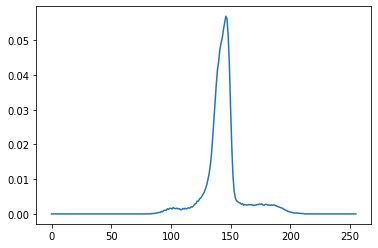

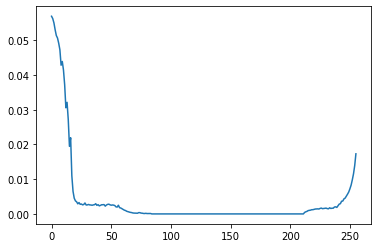

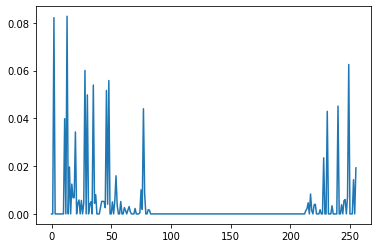

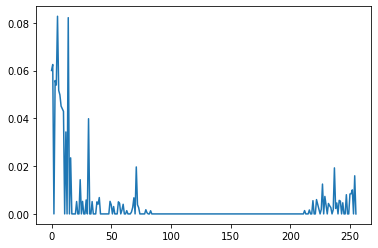

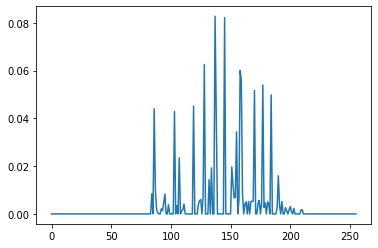

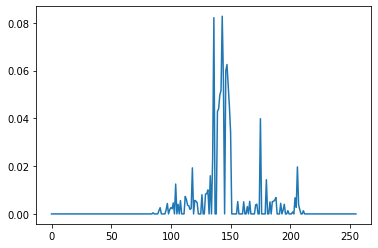

In [79]:
# Entropy constrained MSB and Random LSBs  
dual_mip_xx = results[11]
mip_random_msb = intensities.copy() #0

for i in range(0,height):
    for j in range(0,width):
        paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
        if prbs[intensities[i][j]] < prbs[paired_cell]:
            mip_random_msb[i][j] = paired_cell[0]
            
mip_entropy_distortion0 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam1000000_msb0', mip_random_msb)
filename = '2_lam1000000_msb0.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr0 = correlations(mip_random_msb)
print('\n2_lam1000000_correlation_msb0:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam1000000_histogram_msb0')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam1000000_msb0_entropy ', entropy)


mip_random_msb = intensities.copy() #1

for i in range(0,height):
    for j in range(0,width):
        paired_cell = np.where(dual_mip_xx[intensities[i][j]] == 1)
        if prbs[intensities[i][j]] > prbs[paired_cell]:
            mip_random_msb[i][j] = paired_cell[0]
            
mip_entropy_distortion1 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam1000000_msb1', mip_random_msb)
filename = '2_lam1000000_msb1.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr1 = correlations(mip_random_msb)
print('\n2_lam1000000_correlation_msb1:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam1000000_histogram_msb1')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam1000000_msb1_entropy ', entropy)


mip_1msb_distortion_1 = 0.5*(mip_entropy_distortion0+mip_entropy_distortion1)
mip_1msb_distortion = 10*np.log10(mip_1msb_distortion_1)
print('2_lam1000000_1msb_distortion ',mip_1msb_distortion)

hcorr_1msb = (corr0[0]+corr1[0])/2
vcorr_1msb = (corr0[1]+corr1[1])/2
dcorr_1msb = (corr0[2]+corr1[2])/2

print('2_lam1000000_average_hcorr_1msb',hcorr_1msb)
print('2_lam1000000_average_vcorr_1msb',vcorr_1msb)
print('2_lam1000000_average_dcorr_1msb',dcorr_1msb)


mip_random_msb = intensities.copy() #00
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)-64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
            
mip_entropy_distortion00 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam1000000_msb00', mip_random_msb)
filename = '2_lam1000000_msb00.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr00 = correlations(mip_random_msb)
print('\n2_lam1000000_correlation_msb00:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam1000000_histogram_msb00')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam1000000_msb00_entropy ', entropy)


mip_random_msb = intensities.copy() #01
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)+64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter1
            else:
                mip_random_msb[i][j] = alter2
            
mip_entropy_distortion01 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam1000000_msb01', mip_random_msb)
filename = '2_lam1000000_msb01.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr01 = correlations(mip_random_msb)
print('\n2_lam1000000_correlation_msb01:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam1000000_histogram_msb01')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam1000000_msb01_entropy ', entropy)


mip_random_msb = intensities.copy() #10
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)-64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
            
mip_entropy_distortion10 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam1000000_msb10', mip_random_msb)
filename = '2_lam1000000_msb10.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr10 = correlations(mip_random_msb)
print('\n2_lam1000000_correlation_msb10:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam1000000_histogram_msb10')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam1000000_msb10_entropy ', entropy)


mip_random_msb = intensities.copy() #11
for i in range(0,height):
    for j in range(0,width):
        pair_index_raw = np.where(pairs_with_index == intensities[i][j])
        position = pair_index_raw[1][0]
        pair_index = pairs_with_index[2][position]
        
        if 0 <= pair_index < 64: 
            paired_pair_index = int(pair_index)+64
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
                
        if 64 <= pair_index < 128: 
            paired_pair_index = int(pair_index)
            index_position = np.where(pairs_with_index == paired_pair_index)[1][1]
            alter1 = ord_pairs[0][index_position]
            alter2 = ord_pairs[1][index_position]
            if prbs[alter1] < prbs[alter2]:
                mip_random_msb[i][j] = alter2
            else:
                mip_random_msb[i][j] = alter1
            
mip_entropy_distortion11 = eve_distortion(mip_random_msb)

cv2.imshow('2_lam1000000_msb11', mip_random_msb)
filename = '2_lam1000000_msb11.webp'
cv2.imwrite(filename, mip_random_msb)
cv2.waitKey(1000)

corr11 = correlations(mip_random_msb)
print('\n2_lam1000000_correlation_msb11:\n')
correlations(mip_random_msb)

#Histogram
unique_eve, counts_eve = np.unique(mip_random_msb, return_counts=True)

u = unique_eve.copy()
c = counts_eve.copy()
for i in range(0,unique_eve[-1]+1):
    if u[i] != i:
        u = np.insert(u,i,i)
        c = np.insert(c,i,0)

z = np.zeros(255-unique_eve[-1])
all_counts_eve = np.append(c,z)
a = np.array(range(unique_eve[-1]+1, 256))
var_eve = np.append(u,a)

occurance_sum_eve = sum(all_counts_eve)
prbs_eve = all_counts_eve/occurance_sum_eve
plt.figure()
plt.plot(var_eve, prbs_eve)
plt.savefig('2_lam1000000_histogram_msb11')

prbs_eve = np.where(prbs_eve == 0, 0.000000001, prbs_eve)
ent1 = np.log2(prbs_eve)
ent2 = ent1 * prbs_eve
entropy = -np.sum(ent2)
print('2_lam1000000_msb11_entropy ', entropy)

mip_entropy_2msb_distortion_1 = 0.25*(mip_entropy_distortion00
                                     +mip_entropy_distortion01
                                     +mip_entropy_distortion10
                                     +mip_entropy_distortion11)
mip_entropy_2msb_distortion = 10*np.log10(mip_entropy_2msb_distortion_1)
print('2_lam1000000_2msb_distortion ',mip_entropy_2msb_distortion)


hcorr_2msb = (corr00[0]+corr01[0]+corr10[0]+corr11[0])/4
vcorr_2msb = (corr00[1]+corr01[1]+corr10[1]+corr11[1])/4
dcorr_2msb = (corr00[2]+corr01[2]+corr10[2]+corr11[2])/4

print('2_lam1000000_average_hcorr_2msb',hcorr_2msb)
print('2_lam1000000_average_vcorr_2msb',vcorr_2msb)
print('2_lam1000000_average_dcorr_2msb',dcorr_2msb)

In [80]:
cv2.destroyAllWindows()